In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from tensorflow import keras
from uproot_io import Events, View

# Building a CNN for event classification.

We're only using **perfect reconstruction** (cheated files) for this.

1. Need to obtain the truth record for each event, 0 for CC_mu, 1 for CC_e and 2 for NC_x. 


In [4]:
# the data
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [5]:
event_numbers = np.array(list(set(events.event_number)))
event_numbers, len(event_numbers)

(array([   0,    1,    2, ..., 9307, 9308, 9309]), 9310)

# Labelling the events

In [6]:
def labelling():
    label = []
#     bad = []
    
    for n in event_numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])
                
#         if 13 in mcp and 11 in mcp:
#             bad.append(n)
#             label.append(3)
        
        if 13 in mcp or -13 in mcp:
            label.append(0)

        elif 11 in mcp or -11 in mcp:
            label.append(1)    
            
        else:
            label.append(2)
            
    return np.array(label)

In [7]:
labels = labelling()

9310


((array([3512.,    0.,    0.,    0.,    0., 3715.,    0.,    0.,    0.,
         2083.]),
  array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
  <BarContainer object of 10 artists>),
 None)

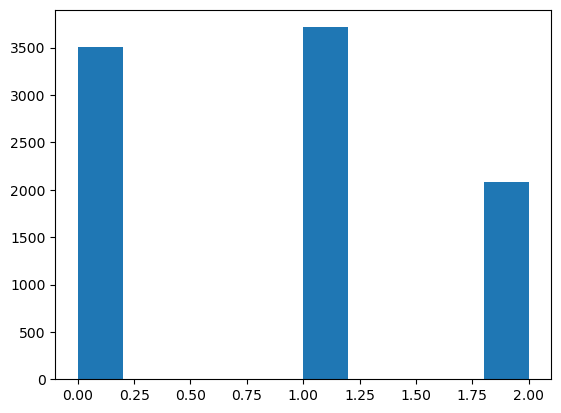

In [8]:
plt.hist(labels), print(len(labels))

In [9]:
def oneHotLabelling():
    label = []
    
    for n in event_numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])

        if 11 in mcp or -11 in mcp:
            label.append([0,1,0])    
        
        elif 13 in mcp or -13 in mcp:
            label.append([1,0,0])
            
        else:
            label.append([0,0,1])
            
    return np.array(label).astype(float)

In [10]:
one_hot_labels = oneHotLabelling()

# Making the images

In [11]:
view_w = View(events, "w")

In [12]:
def plot_w_event(number):
    x = view_w.x[number]
    z = view_w.z[number]
    adc = view_w.adc[number]
    vx = view_w.true_vtx_x[number]
    vz = view_w.true_vtx_z[number]
    
    plt.scatter(x, z, c=adc, s=0.5)
    plt.scatter(vx, vz, c='red', s=50)
    cbar = plt.colorbar()
    cbar.set_label('ADC')
    plt.xlabel('Time')
    plt.ylabel('W Wire')
    plt.show()

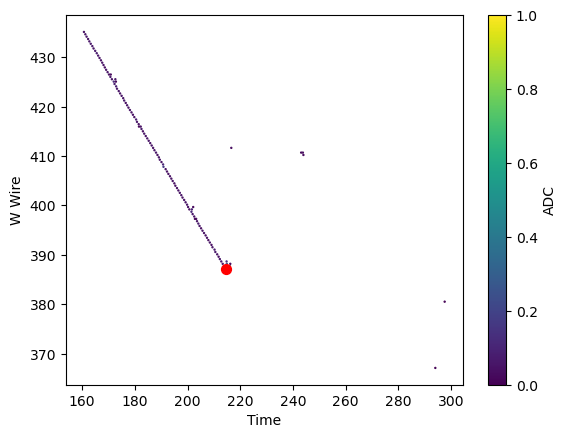

In [13]:
plot_w_event(114)

In [14]:
def image():
    
    images = []
    
    for n in event_numbers:
    
        x = view_w.x[n]
        z = view_w.z[n]
        adc = view_w.adc[n]

        matrix_size = 128
        matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[min(x), max(x)], [min(z), max(z)]], weights=adc)

        matrix = np.floor(matrix).astype(np.uint8).reshape(128, 128, 1)
        images.append(matrix)
        

#         # Display the pixelated image
#         plt.imshow(matrix.T, cmap='viridis', origin='lower', extent=[0, 128, 0, 128])
#         plt.colorbar()
#         plt.title('Pixelated Image of Energy')
#         plt.show()
    
    return np.stack(images)

In [80]:
images = image()
print(images)

[[[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]]


 [[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [182]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]]


 [[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
   [  0]
   

In [16]:
training = np.load("training_events.npy")
testing = np.load("testing_events.npy")

In [17]:
x_train = images[training]
y_train = one_hot_labels[training]

x_test = images[testing]
y_test = one_hot_labels[testing]

In [18]:
num_classes = 3

# The CNN

In [46]:
input_layer = keras.layers.Input(x_train[0].shape)
x = keras.layers.Conv2D(32, (3,3), activation='relu')(input_layer) # Replace None with a 2D convolution with 32 filters of size (3,3) and relu activation
x = keras.layers.MaxPooling2D((2,2))(x) # Replace None with a MaxPooling2D layer to downsample by a factor of 2 in both dimensions
x = keras.layers.Dropout(0.25)(x) # Replace None with a droput layer with a fraction of 0.25
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(num_classes, activation='softmax')(x) # Replace None with a final dense output layer with num_classes neurons and softmax activation
cnn_model = keras.Model(input_layer, x)
cnn_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 127008)            0         
                                                                 
 dense_6 (Dense)             (None, 3)                 381027    
                                                           

In [47]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 7
# The learning rate (step size in gradient descent)
learning_rate = 0.001

In [48]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
cnn_model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [49]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
cnn_model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
              validation_data = (x_test, y_test), verbose = 1)


Epoch 1/7
51/51 [==============================] - 18s 347ms/step - loss: 16.0834 - accuracy: 0.4998 - val_loss: 6.8846 - val_accuracy: 0.5897
Epoch 2/7
51/51 [==============================] - 19s 365ms/step - loss: 1.7252 - accuracy: 0.8033 - val_loss: 3.2697 - val_accuracy: 0.6899
Epoch 3/7
51/51 [==============================] - 19s 371ms/step - loss: 0.3310 - accuracy: 0.9248 - val_loss: 2.9049 - val_accuracy: 0.7257
Epoch 4/7
51/51 [==============================] - 19s 368ms/step - loss: 0.1091 - accuracy: 0.9661 - val_loss: 2.8886 - val_accuracy: 0.7368
Epoch 5/7
51/51 [==============================] - 20s 384ms/step - loss: 0.0542 - accuracy: 0.9828 - val_loss: 2.8260 - val_accuracy: 0.7311
Epoch 6/7
51/51 [==============================] - 19s 366ms/step - loss: 0.0397 - accuracy: 0.9862 - val_loss: 2.9340 - val_accuracy: 0.7361
Epoch 7/7
51/51 [==============================] - 19s 369ms/step - loss: 0.0340 - accuracy: 0.9879 - val_loss: 2.8567 - val_accuracy: 0.7376


In [79]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = cnn_model.predict(x = x_test[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

22/22 [==============================] - 2s 70ms/step
Number of images that were incorrectly classified = 733


Incorrect classification for image 196 : predicted = 1 with true = 2


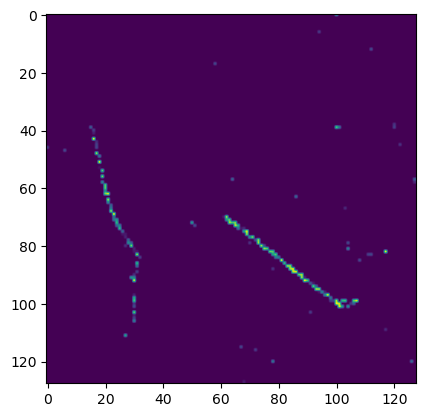

In [69]:
# Now you can modify this part to draw different images from the failures list
# You can change the value of im to look at different failures
im = 53
image_to_plot = x_test[incorrect_indices[im][0]]
fig, ax = plt.subplots(1, 1)
print('Incorrect classification for image',incorrect_indices[im][0],
      ': predicted =',incorrect_indices[im][1],
      'with true =',incorrect_indices[im][2])
ax.imshow(image_to_plot)

In [73]:
from sklearn.metrics import confusion_matrix

preds = []
trut = []
for i in range(0,n_images_to_check):
    prediction = np.argmax(raw_predictions[i])
    truth = np.argmax(y_test[i])
    preds.append(prediction)
    trut.append(truth)
    
conf_matrix = confusion_matrix(trut, preds)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


In [74]:
conf_matrix_decimals

array([[0.77362205, 0.15944882, 0.06692913],
       [0.1284965 , 0.78409091, 0.08741259],
       [0.15323855, 0.25118483, 0.59557662]])

Text(50.722222222222214, 0.5, 'True Label')

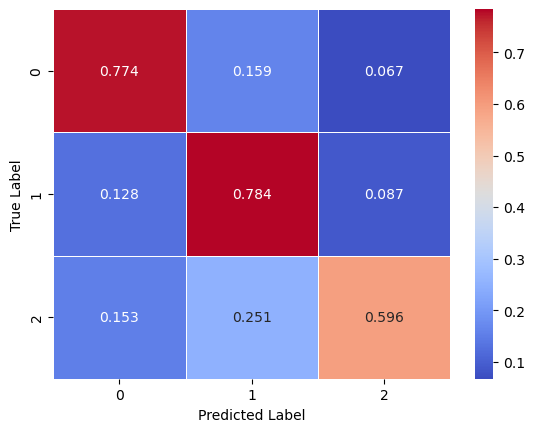

In [78]:
import seaborn as sns
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')